## Creating CNN-LSTM model 

In [1]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [54]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input , Conv2D , MaxPooling2D , Dropout , TimeDistributed
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [3]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix , accuracy_score

In [4]:
actions = np.array(['hello' , 'thankyou' ,'iloveyou'])

# Creating Label Map 

label_map = {label:num for num,label in enumerate(actions)}

In [8]:
label_map

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}

In [9]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [10]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [11]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [12]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 300/300 [00:00<00:00, 425.66it/s]


In [21]:
np.array(df['Landmarks'][0]).shape

(30, 1662)

In [25]:
df['Landmarks'][0][0][0]

0.5282081961631775

To feed it into Conv2D , we need input in the shape of (height , width , channel)

In [27]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda row : np.array(row).reshape(30 , 1662 , 1) )

100%|██████████| 300/300 [00:00<00:00, 2350.23it/s]


In [28]:
df["Landmarks"][0].shape

(30, 1662, 1)

In [29]:
df['Landmarks'][0][0][0]

array([0.5282082])

In [41]:
# Deducing X and y vaues to split

X = np.array(df['Landmarks'].tolist())

labels_list = (df['Labels'].tolist())

y = to_categorical(labels_list).astype(int)
 

In [40]:
labels_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [37]:
X.shape

(300, 30, 1662, 1)

In [43]:
y.shape

(300, 3)

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [44]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [46]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , y_test.shape)

X-train shape: (285, 30, 1662, 1)
X-test shape: (15, 30, 1662, 1)
y-train shape: (285, 3)
y-test shape: (15, 3)


#### Creating CNN_LSTM Model Arhictecture

In [47]:
X_train.shape

(285, 30, 1662, 1)

In [49]:
actions.shape[0]

3

In [55]:
def create_LRCN_model(): 

 """"
 This function will construct the required  LRCN model architecture. 

 Returns:
  model : Required LRCN model

 """

 # We will use a Sequential Model Architecture

 model = Sequential()

 # Defining the Model Architecture

 model.add(Input(shape=(30 , 1662,1)))

 #CNN Layer 1
 model.add((Conv2D(filters= 16 , kernel_size= (3,3) , padding='same' , activation='relu')))
 model.add((MaxPooling2D((2,2))))
 model.add((Dropout(0.25)))

  #CNN Layer 2
 model.add((Conv2D(filters= 32 , kernel_size= (3,3) , padding='same' , activation='relu')))
 model.add((MaxPooling2D((2,2))))
 model.add((Dropout(0.25)))

 #  #CNN Layer 3
 # model.add((Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # # model.add(TimeDistributed(MaxPooling2D((1,2))))
 # model.add((Dropout(0.25)))
 
   #CNN Layer 4
 model.add((Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 # model.add(TimeDistributed(Dropout(0.25)))

 model.add((TimeDistributed(Flatten())))

 # Feeding the extracted features to the LSTM layers

 model.add(LSTM(32))

 #Adding dese layer for classification 

 model.add(Dense(actions.shape[0] , activation='softmax' ))

 #Display model summary

 model.summary()

 #Return the constructed LRCN model

 return model

In [56]:
# construct the model

LRCN_model = create_LRCN_model()

print('Model Created Successfuly')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 1662, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 831, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 831, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 831, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 415, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 415, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 415, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 26560)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │     3,403,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,427,299 (13.07 MB)

 Trainable params: 3,427,299 (13.07 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfuly


In [57]:
LRCN_model.compile(optimizer= 'Adam' , loss = 'categorical_crossentropy' , metrics =['categorical_accuracy'])

In [58]:
LRCN_model_history = LRCN_model.fit(X_train , y_train , epochs= 100  , validation_split=0.2)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step - categorical_accuracy: 0.3539 - loss: 1.4173 - val_categorical_accuracy: 0.4211 - val_loss: 1.0688
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - categorical_accuracy: 0.4543 - loss: 1.0886 - val_categorical_accuracy: 0.2807 - val_loss: 1.0856
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - categorical_accuracy: 0.3689 - loss: 1.0727 - val_categorical_accuracy: 0.2807 - val_loss: 1.0659
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - categorical_accuracy: 0.4680 - loss: 1.0183 - val_categorical_accuracy: 0.2982 - val_loss: 0.9652
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - categorical_accuracy: 0.4467 - loss: 0.9081 - val_categorical_accuracy: 0.5789 - val_loss: 0.8407
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - categorical_accuracy: 0.5393 - loss: 0.8345 - val_categorical_accuracy: 0.5789 - val_loss: 0.8072
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - categorical_accuracy: 0.6624 - loss: 0.78

#### Analyzing Training Results

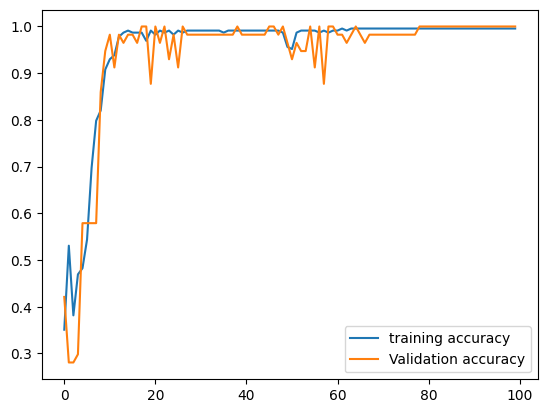

In [60]:
plt.plot(LRCN_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.plot(LRCN_model_history.history['val_categorical_accuracy'] , label = 'Validation accuracy')
plt.legend(loc ='lower right')

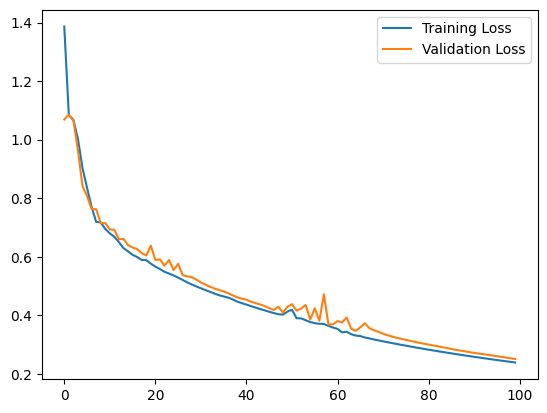

In [61]:
plt.plot(LRCN_model_history.history['loss'] , label = 'Training Loss')
plt.plot(LRCN_model_history.history['val_loss'] , label = 'Validation Loss')
plt.legend(loc = 'upper right')

In [62]:
LRCN_model.evaluate(X_test , y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_accuracy: 1.0000 - loss: 0.1850


[0.18499919772148132, 1.0]

#### Predicting Results

In [63]:
predictions = LRCN_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


In [64]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [65]:
comparision_df = pd.DataFrame({'y_true' : actual , 'y_pred': results})

In [66]:
comparision_df

,y_true,y_pred
0,thankyou,thankyou
1,hello,hello
2,thankyou,thankyou
3,thankyou,thankyou
4,iloveyou,iloveyou
5,iloveyou,iloveyou
6,iloveyou,iloveyou
7,thankyou,thankyou
8,thankyou,thankyou
9,iloveyou,iloveyou


#### 4. Saving the Model

In [67]:
with open("LRCN_model" , 'wb') as file:
 pickle.dump(LRCN_model , file)

In [68]:
y_hat = predictions

In [70]:
y_hat.shape

(15, 3)

In [74]:
np.argmax(y_hat[0])

1

In [75]:
y_test

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [76]:
y_hat = np.argmax(y_hat , axis = 1).tolist()
y_true = np.argmax(y_test , axis = 1).tolist()

In [77]:
multilabel_confusion_matrix(y_true , y_hat)

array([[[12,  0],
        [ 0,  3]],

       [[ 7,  0],
        [ 0,  8]],

       [[11,  0],
        [ 0,  4]]], dtype=int64)

In [78]:
accuracy_score(y_true , y_hat)

1.0